# Procesamiento Digital de Señales - 2do Cuatrimestre 2025

## Trabajo Semanal 2 - Transformada Discreta de Fourier

**Alumno**: Bruno Glecer

**Profesor**: Dr. Mariano Llamedo Soria

## Consigna

Desarrollar un algoritmo que calcule la transformada discreta de Fourier (DFT).

$$\Large X[k] = \sum^{N-1}_{n=0} x[n] e^{-2\pi j k n /N}$$

## Utilidades

In [1]:
import numpy as np
from scipy.signal import chirp
import matplotlib.pyplot as plt
from time import perf_counter

def sampled_sine(nn, fs, vmax=1, dc=0, ff=1, ph=0):
    tt = np.linspace(0, nn/fs, num=nn, endpoint=False)
    xx = vmax*np.sin(2*np.pi*ff*tt + ph) + dc
    return tt, xx

## Resolución

### DFT Iterativo

Se implementó el algroritmo de DFT con dos bucles for anidados

In [2]:
def dft1(x):
    N = len(x)
    x_dft = np.zeros(N, dtype=np.complex128)
    for k in range(N):
        for n in range(N):
            x_dft[k] += x[n]*np.exp(-2j*k*np.pi*n/N)
    return x_dft

### DFT Matricial

Se utilizó la libreria numpy para producir la siguiente matriz mediante el producto tensorial entre dos vectores

$$M = \begin{bmatrix} 0 & 1 & \cdots & (N-1) \end{bmatrix} \otimes \begin{bmatrix} 0 \\ 1 \\ \cdots \\ (N-1) \end{bmatrix}  = \begin{bmatrix}
0\cdot 0 & 0\cdot 1 & \cdots & 0\cdot (N-1) \\
1\cdot 0 & 1\cdot 1 & \cdots & 1\cdot (N-1) \\
2\cdot 0 & 2\cdot 1 & \cdots & 2\cdot (N-1) \\
\vdots & \vdots & \ddots & \vdots \\
(N-1)\cdot 0 & (N-1)\cdot 1 & \cdots & (N-1)\cdot (N-1)
\end{bmatrix}$$

Luego cada elemento se multiplica por $-\frac{2\pi j}{N}$ y se le aplica la función exponencial resultando en la matriz `twiddle`:

$$T =
\begin{bmatrix}
1 & 1 & 1 & \cdots & 1 \\
1 & e^{-\tfrac{2\pi i}{N}\cdot 1\cdot 1} & e^{-\tfrac{2\pi i}{N}\cdot 1\cdot 2} & \cdots & e^{-\tfrac{2\pi i}{N}\cdot 1\cdot (N-1)} \\
1 & e^{-\tfrac{2\pi i}{N}\cdot 2\cdot 1} & e^{-\tfrac{2\pi i}{N}\cdot 2\cdot 2} & \cdots & e^{-\tfrac{2\pi i}{N}\cdot 2\cdot (N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & e^{-\tfrac{2\pi i}{N}\cdot (N-1)\cdot 1} & e^{-\tfrac{2\pi i}{N}\cdot (N-1)\cdot 2} & \cdots & e^{-\tfrac{2\pi i}{N}\cdot (N-1)\cdot (N-1)}
\end{bmatrix}$$

El resultado de la multiplicación de la matriz `twiddle` con el vector columna de los valores de la señal, resulta en la DFT de la señal $\mathbf{X}$

$$\mathbf{X}_{\mathrm{DFT}} = T \cdot \mathbf{X}
= \begin{bmatrix}
\sum_{k=0}^{N-1} e^{-\frac{2\pi i}{N}(0)k}x[k],\\
\sum_{k=0}^{N-1} e^{-\frac{2\pi i}{N}(1)k}x[k],\\
\vdots \\
\sum_{k=0}^{N-1} e^{-\frac{2\pi i}{N}(N-1)k}x[k]
\end{bmatrix}$$


In [3]:
def dft2(x):
    N = len(x)
    n = range(N)
    M = np.pi*np.tensordot(n, n, axes=0)
    twiddle = np.exp(-1j*2*M/N)
    x_dft = np.dot(twiddle, x.reshape(N,1))
    return x_dft.flatten()

## Pruebas

Para probar las funciones de DFT, se definió una señal compuesta por tres señales senoidales con distintas amplitudes, frecuencias y fases

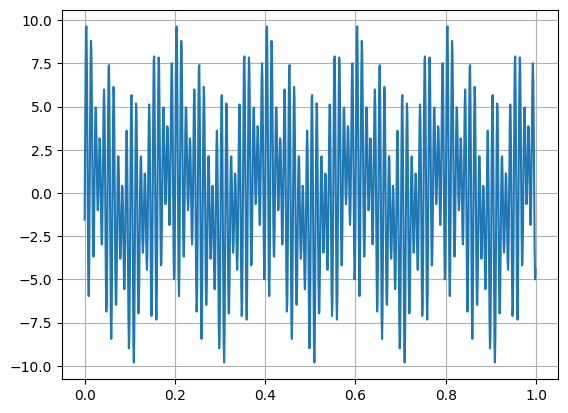

In [4]:
fs = 1000
N = 1000

t1, sin1 = sampled_sine(N, fs, ff=5, vmax=2, ph=np.pi/2)
t2, sin2 = sampled_sine(N, fs, ff=80, vmax=3, ph=0)
t2, sin3 = sampled_sine(N, fs, ff=100, vmax=5, ph=-np.pi/4)

t, signal = t1, sin1 + sin2 + sin3

plt.plot(t,signal)
plt.grid()
plt.show()

### DFT Iterativa

(0.0, 150.0)

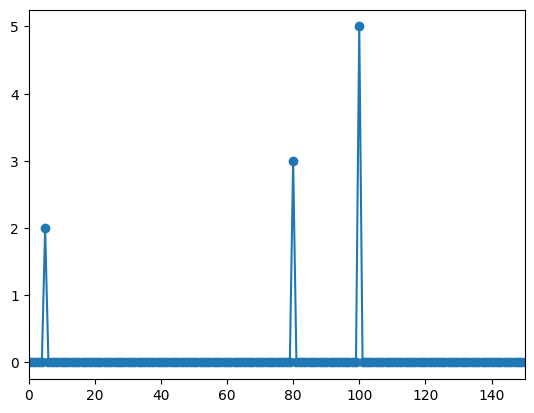

In [5]:
t1 = perf_counter() 
signal_dft1 = dft1(signal)
t1 = perf_counter() - t1

freq = np.fft.fftfreq(N, d=1/fs)

plt.scatter(freq[:N//2], np.abs(signal_dft1)[:N//2]*2/N)
plt.plot(freq[:N//2], np.abs(signal_dft1)[:N//2]*2/N)
plt.xlim(0,150)

Se pueden ver las tres componentes de la señal en 5 Hz, 80 Hz y 100 Hz. A simple vista parece que la función `dft1` funciona correctamente. Se utilizó `np.fft.fftfreq` para obtener el eje de frecuencias que corresponden con cada elemento de la DFT. Solo se graficaron frecuencias positivas.

### DFT Matricial

(0.0, 150.0)

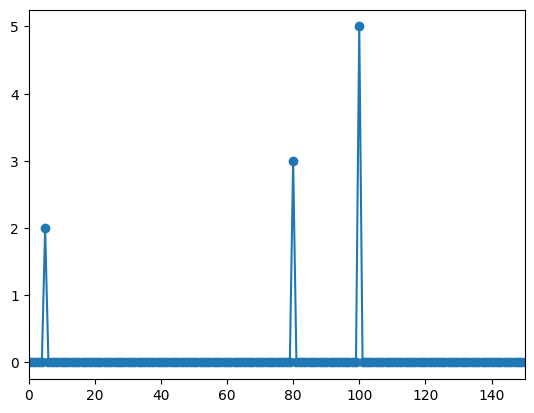

In [6]:
t2 = perf_counter() 
signal_dft2 = dft2(signal)
t2 = perf_counter() - t2

freq = np.fft.fftfreq(N, d=1/fs)

plt.scatter(freq[:N//2], np.abs(signal_dft2)[:N//2]*2/N)
plt.plot(freq[:N//2], np.abs(signal_dft2)[:N//2]*2/N)
plt.xlim(0,150)

Se puede ver como la segunda función para calcular DFT definida, también aparenta funcionar correctamente.

### Verificación con FFT de NumPy

Para realizar una prueba mas rigurosa de la validez de las funciones definidas, se calculó la DFT utilizando la función `fft.fft` de la libreria NumPy y luego se compararon las partes reales y complejas, conisderando una cierta tolerancia.

In [7]:
tolerance = 1e-8


t3 = perf_counter() 
signal_fft = np.fft.fft(signal)
t3 = perf_counter() - t3

dft1_diff = np.abs(signal_dft1 - signal_fft)

if np.any(dft1_diff > tolerance):
    print("DFT1 ERROR")
else:
    print("DFT1 OK")

dft2_diff = np.abs(signal_dft2 - signal_fft)

if np.any(dft2_diff > tolerance):
    print("DFT2 ERROR")
else:
    print("DFT2 OK")



DFT1 OK
DFT2 OK


### Comparación de tiempos

A continuación se muestra el tiempo de ejecución para los tres métodos de cálculo de DFT utilizados.
El más lento fue el método iterativo, lo cual era de esperar debido a la necesidad de ejecutar N^2 veces una multiplicación directamente sobre la capa de Python.

El método matricial tiene un rendimiento 12 veces mayor al primero, mostrando como se puede optimizar el tiempo de ejecución simplificando problemas a operaciónes matriciales y utilizando la librería NumPy. Finlamente, el algoritmo FFT implementado en NumPy, tiene un tiempo de ejecución 500 veces menor al método matricial. Debido a esta diferencia enorme en tiempo, el algoritmo FFT es casi exclusivamente utilizado para el cálculo de DFTs.

[Text(0, 0, '2667.00 ms'), Text(0, 0, '286.85 ms'), Text(0, 0, '1.64 ms')]

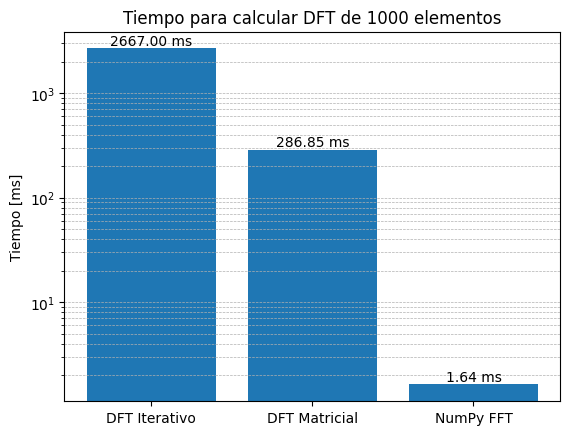

In [8]:
bars = plt.bar(['DFT Iterativo', 'DFT Matricial', 'NumPy FFT'], [t1*1000, t2*1000, t3*1000])
plt.ylabel("Tiempo [ms]")
plt.yscale("log")
plt.title("Tiempo para calcular DFT de 1000 elementos")
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.bar_label(bars, fmt="%.2f ms")

#

### Prueba: Ruido Aleatorio

Se calculó la DFT de dos señales de ruido uniforme con distintas varianzas. A simpe vista se puede ver como la señal con mayor varianza también tiene un espectro mas disperso.

Text(0.5, 0, 'Frecuencia (Hz)')

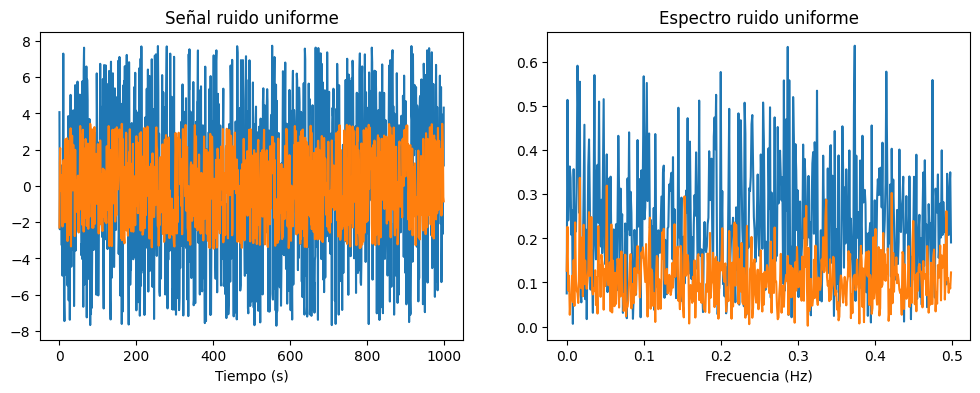

In [9]:
N = 1000
var1 = 20
var2 = 4

a1 = np.sqrt(3 * var1)
a2 = np.sqrt(3 * var2)

noise1 = 2*a1*np.random.random_sample(N) - a1
noise2 = 2*a2*np.random.random_sample(N) - a2

freq = np.fft.fftfreq(N, d=1)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

noise1_fft = np.fft.fft(noise1)
noise2_fft = np.fft.fft(noise2)

axs[0].plot(noise1)
axs[0].plot(noise2)
axs[0].set_title("Señal ruido uniforme")
axs[0].set_xlabel("Tiempo (s)")
axs[1].plot(freq[:N//2], np.abs(noise1_fft)[:N//2]*2/N)
axs[1].plot(freq[:N//2], np.abs(noise2_fft)[:N//2]*2/N)
axs[1].set_title("Espectro ruido uniforme")
axs[1].set_xlabel("Frecuencia (Hz)")

